In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

In [ ]:
#pip install scalecast

In [2]:
# read data
data = pd.read_csv('forecasting data_ALL.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['PlantID','Material_Code','Date'])


In [3]:
data.head()

,PlantID,Material_Code,STG_Week,Sales_Qty,Week_Number,Year,Week_Number_updated,Date
129,DC-1,P-001,27_2021,28,27,2021,1,2021-07-05
679,DC-1,P-001,28_2021,41,28,2021,2,2021-07-12
1229,DC-1,P-001,29_2021,32,29,2021,3,2021-07-19
1779,DC-1,P-001,30_2021,34,30,2021,4,2021-07-26
2329,DC-1,P-001,31_2021,29,31,2021,5,2021-08-02


In [4]:
input_data={}
for plant in data.PlantID.unique():
    for mat in data.Material_Code.unique():
        data_slice = data.loc[(data['PlantID'] == plant) & (data['Material_Code'] == mat)]
        #load_dates = pd.date_range(start=data_slice['Date'].min(),end=data_slice['Date'].max()) # for missing weeks, assume 0
        load_dates = pd.to_datetime(data_slice.Date)
        data_load = pd.DataFrame({'Date':load_dates})
        data_load['Vol'] = data_load.merge(data_slice,how='left',on='Date')['Sales_Qty'].values
        f = Forecaster(y=data_load['Vol'],current_dates=data_load['Date'],PlantID=plant,Material_Code=mat)
        input_data[f"{plant}-{mat}"] = f

C:\Users\Supriya Malla\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


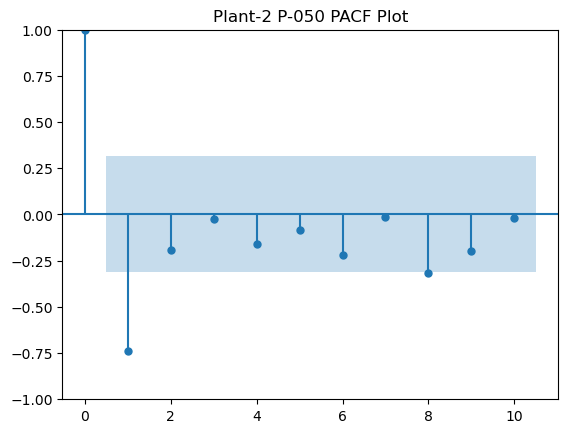

In [5]:
f.plot_pacf(diffy=True,lags=10)
plt.title(f'{f.PlantID} {f.Material_Code} PACF Plot')
plt.show()

In [6]:
# download template validation grids (will not overwrite existing Grids.py file by default)
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

In [7]:
for k, f in input_data.items():
    f.generate_future_dates(12) #I want to predict for the next 12 weeks (3 months)
    f.set_test_length(10)
    f.set_validation_length(5)
    f.add_ar_terms(3)
    f.add_AR_terms((1,10))
    if not f.adf_test(): # returns True if it thinks it's stationary, False otherwise
        f.diff()
    f.add_seasonal_regressors('week','month','quarter',raw=False,sincos=True)
    f.add_seasonal_regressors('year')
    f.add_time_trend()

In [8]:
from tqdm.notebook import tqdm as log_progress
models = ('mlr','knn','svr','xgboost','gbt','elasticnet','mlp', 'rf')
for k, f in log_progress(input_data.items()):
    for m in models:
        
        f.set_estimator(m)
        f.tune() # by default, will pull the grid with the same name as the estimator (mlr will pull the mlr grid, etc.)
        f.auto_forecast()

    # combine models and run manually specified models of other varieties
    f.set_estimator('combo')
    f.manual_forecast(how='weighted',models=models,determine_best_by='ValidationMetricValue',call_me='weighted')
    f.manual_forecast(how='simple',models='top_5',determine_best_by='ValidationMetricValue',call_me='avg')


  0%|          | 0/550 [00:00<?, ?it/s]

In [9]:
forecast_info = pd.DataFrame()
forecast_info1=pd.DataFrame()
for k, f in input_data.items():
    
    
    df = f.export(dfs=['lvl_fcsts'],determine_best_by='LevelTestSetMAPE')
    df1 = f.export(dfs=['model_summaries'],determine_best_by='LevelTestSetMAPE')    
    df['Name'] = k
    df['Plant'] = f.PlantID
    df['Material Code'] = f.Material_Code
    
    df1['Name'] = k
    df1['Plant'] = f.PlantID
    df1['Material Code'] = f.Material_Code
    
    forecast_info = pd.concat([forecast_info,df],ignore_index=True)
    forecast_info1 = pd.concat([forecast_info1,df1],ignore_index=True)
    
writer = pd.ExcelWriter('model_summaries.xlsx')
forecast_info.to_excel(writer,sheet_name='Sheet1',index=False)
forecast_info1.to_excel(writer,sheet_name='Sheet2',index=False)
writer.save()

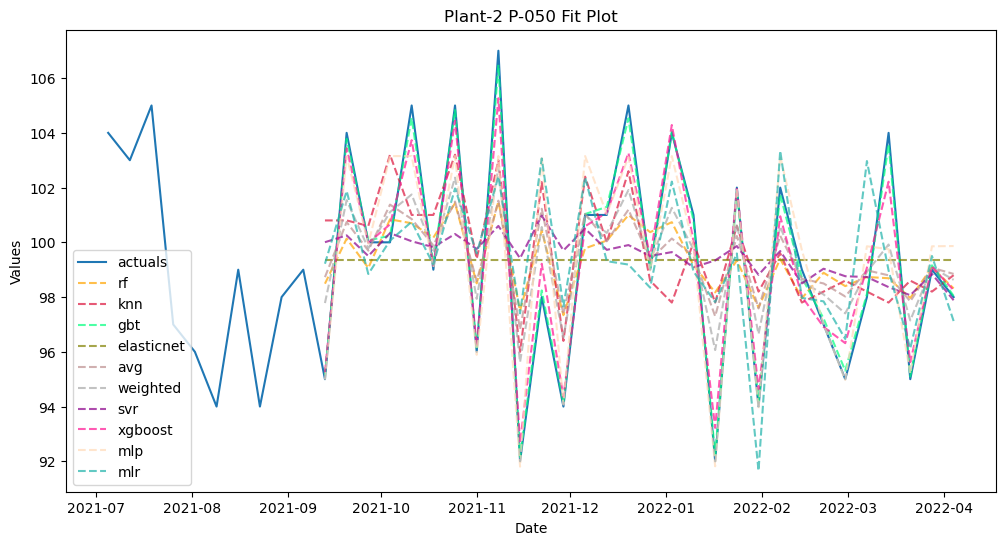

In [11]:
f.plot_fitted(order_by='LevelTestSetMAPE')
plt.title(f'{f.PlantID} {f.Material_Code} Fit Plot')
plt.show()

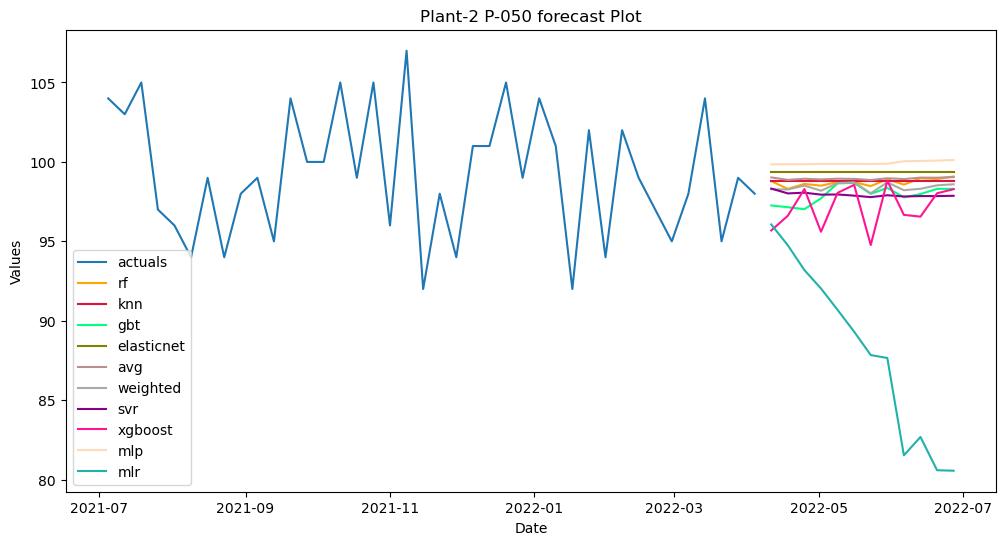

In [12]:
f.plot(order_by='LevelTestSetMAPE') # plots all forecasts
plt.title(f'{f.PlantID} {f.Material_Code} forecast Plot')
plt.show()